# 完全卷积网络
:label:`sec_fcn`

正如 :numref:`sec_semantic_segmentation` 中所讨论的那样，语义分割以像素级别对图像进行分类。完全卷积网络 (FCN) 使用卷积神经网络将图像像素转换为像素类 :cite:`Long.Shelhamer.Darrell.2015`。与我们之前在图像分类或对象检测方面遇到的 CNN 不同，完全卷积网络将中间要素贴图的高度和宽度转换回输入图像的高度和宽度：这是通过 :numref:`sec_transposed_conv` 中引入的转置卷积图层实现的。因此，分类输出和输入图像在像素级别上具有一对应关系：任何输出像素处的通道尺寸都保存在同一空间位置的输入像素的分类结果。


In [1]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l


## 模型

下面我们描述完全卷积网络模型的基本设计。如 :numref:`fig_fcn` 所示，该模型首先使用 CNN 提取图像要素，然后通过 $1\times 1$ 卷积图层将通道数量转换为类数，最后通过引入的转置卷积将要素地图的高度和宽度转换为输入图像的高度和宽度在 :numref:`sec_transposed_conv` 中。因此，模型输出的高度和宽度与输入图像具有相同的高度和宽度，其中输出通道包含位于同一空间位置的输入像素的预测类。 

![Fully convolutional network.](../img/fcn.svg)
:label:`fig_fcn`

下面，我们 [** 使用在 ImageNet 数据集上预训练的 resnet-18 模型来提取影像要素 **] 并将模型实例表示为 `pretrained_net`。该模型的最后几层包括全局平均池层和完全连接的层：完全卷积网络中不需要它们。


In [2]:
pretrained_net = torchvision.models.resnet18(pretrained=True)
list(pretrained_net.children())[-3:]

[Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (downsample): Sequential(
       (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
       (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     )
   )
   (1): BasicBlock(
     (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): Batc

接下来，我们 [** 创建完全卷积网络实例 `net`**]。它复制 Resnet-18 中的所有预训练图层，但最终的全局平均池层和最接近输出的完全连接图层除外。


In [3]:
net = nn.Sequential(*list(pretrained_net.children())[:-2])

给定高度和宽度分别为 320 和 480 的输入，`net` 的正向传播会将输入高度和宽度降至原始高度和宽度的 1/32，即 10 和 15。


In [4]:
X = torch.rand(size=(1, 3, 320, 480))
net(X).shape

torch.Size([1, 512, 10, 15])

接下来，我们 [** 使用 $1\times 1$ 卷积图层将输出通道的数量转换为 Pascal VOC2012 数据集的类数 (21)。**] 最后，我们需要（** 将要素地图的高度和宽度增加 32 倍 **）将其更改回输入图像的高度和宽度。回想一下如何计算 :numref:`sec_padding` 中卷积层的输出形状。自 $(320-64+16\times2+32)/32=10$ 和 $(480-64+16\times2+32)/32=15$ 以来，我们构建了一个跨度为 $32$ 的转置卷积层，将内核的高度和宽度设置为 $64$，填充为 $16$。一般来说，我们可以看到，对于步幅 $s$，填充 $s/2$（假设 $s/2$ 是整数）和内核 $2s$ 的高度和宽度 $2s$，转置卷积将使输入的高度和宽度增加 $s$ 倍。


In [5]:
num_classes = 21
net.add_module('final_conv', nn.Conv2d(512, num_classes, kernel_size=1))
net.add_module(
    'transpose_conv',
    nn.ConvTranspose2d(num_classes, num_classes, kernel_size=64, padding=16,
                       stride=32))

## [** 初始化转置的卷积图层 **]

我们已经知道，转置的卷积图层可以增加要素地图的高度和宽度。在图像处理过程中，我们可能需要扩展图像，即 * upSpling*。
*双线性插值 *
是常用的上采样技术之一。它也经常用于初始化转置卷积层。 

为了解释双线性插值，假设给定输入图像，我们想要计算加样输出图像的每个像素。例如，为了计算坐标 $(x, y)$ 处的输出图像的像素，首先将 $(x, y)$ 映射到输入图像上的坐标 $(x', y')$，例如，根据输入大小与输出大小的比率对输入图像进行坐标 $(x', y')$。请注意，映射的 $x′$ and $y′ $ 是实数。然后，在输入图像上找到离坐标 $(x', y')$ 最接近的四个像素。最后，在坐标 $(x, y)$ 处输出图像的像素是根据输入图像上这四个最接近的像素及其与 $(x', y')$ 的相对距离计算的。  

双线性插值的上采样可以通过转置卷积层实现，内核由以下 `bilinear_kernel` 函数构造。由于空间限制，我们只提供下面 `bilinear_kernel` 函数的实现，而不讨论其算法设计。


In [6]:
def bilinear_kernel(in_channels, out_channels, kernel_size):
    factor = (kernel_size + 1) // 2
    if kernel_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = (torch.arange(kernel_size).reshape(-1, 1),
          torch.arange(kernel_size).reshape(1, -1))
    filt = (1 - torch.abs(og[0] - center) / factor) * \
           (1 - torch.abs(og[1] - center) / factor)
    weight = torch.zeros(
        (in_channels, out_channels, kernel_size, kernel_size))
    weight[range(in_channels), range(out_channels), :, :] = filt
    return weight

让我们 [** 试验双线性插值的上采样 **] 由转置卷积层实现。我们构建了一个将高度和重量加倍的转置卷积层，然后用 `bilinear_kernel` 函数初始化其内核。


In [7]:
conv_trans = nn.ConvTranspose2d(3, 3, kernel_size=4, padding=1, stride=2,
                                bias=False)
conv_trans.weight.data.copy_(bilinear_kernel(3, 3, 4));

阅读图像 `X` 并将上采样输出分配给 `Y`。为了打印图像，我们需要调整频道尺寸的位置。


In [8]:
img = torchvision.transforms.ToTensor()(d2l.Image.open('../img/catdog.jpg'))
X = img.unsqueeze(0)
Y = conv_trans(X)
out_img = Y[0].permute(1, 2, 0).detach()

正如我们所看到的那样，转置的卷积图层将图像的高度和宽度增加两倍。除了坐标中的不同比例外，通过双线性插值缩放的图像和在 :numref:`sec_bbox` 中打印的原始图像看起来相同。


input image shape: torch.Size([561, 728, 3])
output image shape: torch.Size([1122, 1456, 3])


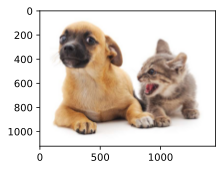

In [9]:
d2l.set_figsize()
print('input image shape:', img.permute(1, 2, 0).shape)
d2l.plt.imshow(img.permute(1, 2, 0))
print('output image shape:', out_img.shape)
d2l.plt.imshow(out_img);

在完全卷积网络中，我们 [** 使用双线性插值的上采样初始化转置的卷积层。对于 $1\times 1$ 卷积层，我们使用 Xavier 初始化。**]


In [10]:
W = bilinear_kernel(num_classes, num_classes, 64)
net.transpose_conv.weight.data.copy_(W);

## [** 阅读数据集 **]

我们阅读了 :numref:`sec_semantic_segmentation` 中介绍的语义分割数据集。随机裁剪的输出图像形状指定为 $320\times 480$：高度和宽度都可以被 $32$ 整除。


In [11]:
batch_size, crop_size = 32, (320, 480)
train_iter, test_iter = d2l.load_data_voc(batch_size, crop_size)

read 1114 examples


read 1078 examples


## [** 培训 **]

现在我们可以训练我们构建的完全卷积网络。这里的损失函数和准确度计算与前面章节的图像分类中的计算并无根本不同。由于我们使用转置卷积图层的输出通道来预测每个像素的类，因此在损失计算中指定了通道维度。此外，准确度是根据所有像素的预测类的正确性来计算的。


In [12]:
def loss(inputs, targets):
    return F.cross_entropy(inputs, targets, reduction='none').mean(1).mean(1)

num_epochs, lr, wd, devices = 5, 0.001, 1e-3, d2l.try_all_gpus()
trainer = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=wd)
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

loss 0.461, train acc 0.858, test acc 0.849
227.4 examples/sec on [device(type='cuda', index=0), device(type='cuda', index=1)]


## [** 预测 **]

预测时，我们需要对每个通道中的输入图像进行标准化，并将图像转换为 CNN 所需的四维输入格式。


In [13]:
def predict(img):
    X = test_iter.dataset.normalize_image(img).unsqueeze(0)
    pred = net(X.to(devices[0])).argmax(dim=1)
    return pred.reshape(pred.shape[1], pred.shape[2])

为了 [** 可视化每个像素的预测类 **]，我们将预测的类映射回其数据集中的标签颜色。


In [14]:
def label2image(pred):
    colormap = torch.tensor(d2l.VOC_COLORMAP, device=devices[0])
    X = pred.long()
    return colormap[X, :]

测试数据集中的图像在大小和形状方面有所不同。由于模型使用步幅为 32 的转置卷积图层，因此当输入图像的高度或宽度不可分为 32 时，转置卷积图层的输出高度或宽度将与输入图像的形状有所偏差。为了解决这个问题，我们可以裁剪多个高度和宽度的矩形区域，这些区域是图像中 32 的整数倍数，然后单独对这些区域的像素进行向前传播。请注意，这些矩形区域的并集需要完全覆盖输入图像。当像素被多个矩形区域覆盖时，可以将该像素在不同区域中转置的卷积输出的平均值输入到 softmax 运算中以预测类。 

为简单起见，我们只读了几张较大的测试图像，然后从图像的左上角开始裁剪 $320\times480$ 区域进行预测。对于这些测试图像，我们逐行打印它们的裁剪区域、预测结果和地面真相。


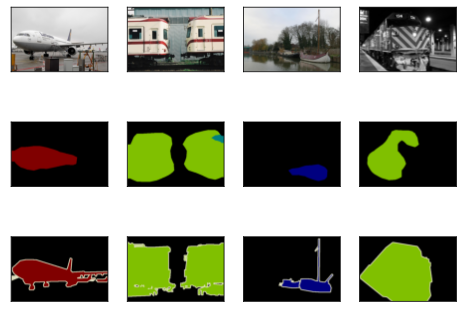

In [15]:
voc_dir = d2l.download_extract('voc2012', 'VOCdevkit/VOC2012')
test_images, test_labels = d2l.read_voc_images(voc_dir, False)
n, imgs = 4, []
for i in range(n):
    crop_rect = (0, 0, 320, 480)
    X = torchvision.transforms.functional.crop(test_images[i], *crop_rect)
    pred = label2image(predict(X))
    imgs += [
        X.permute(1, 2, 0),
        pred.cpu(),
        torchvision.transforms.functional.crop(test_labels[i],
                                               *crop_rect).permute(1, 2, 0)]
d2l.show_images(imgs[::3] + imgs[1::3] + imgs[2::3], 3, n, scale=2);

## 摘要

* 完全卷积网络首先使用 CNN 提取图像要素，然后通过 $1\times 1$ 卷积图层将通道数量转换为类数，最后通过转置卷积将要素地图的高度和宽度转换为输入图像的高度和宽度。
* 在完全卷积网络中，我们可以使用双线性插值的上采样来初始化转置的卷积层。

## 练习

1. 如果我们在实验中使用 Xavier 初始化来转置卷积层，结果会如何改变？
1. 你能通过调整超参数来进一步提高模型的准确性吗？
1. 预测测试图像中所有像素的类别。
1. 最初的完全卷积网络论文还使用 CNN 中间层 :cite:`Long.Shelhamer.Darrell.2015` 的输出。尝试实施这个想法。


[Discussions](https://discuss.d2l.ai/t/1582)
